In [11]:
# URLS 
ELECTION = 'https://static01.nyt.com/elections-assets/2020/data/api/2020-11-03/national-map-page/national/president.json'
COVID = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
POPULATION = 'ozone-county-population.xlsx'  # downloaded from https://www.epa.gov/sites/production/files/2016-04/ozone-county-population.xlsx

In [12]:
import requests
import json
import shutil
import os
import dataflows as DF

In [13]:
# Cache source files
TMP_ELECTION = '.tmp.election.json'
TMP_COVID = '.tmp.covid.csv'
TMP_POP = '.tmp.pop.csv'
if not os.path.exists(TMP_ELECTION):
    with open(TMP_ELECTION, 'wb') as tmp:
        tmp.write(requests.get(ELECTION).content)
if not os.path.exists(TMP_COVID):
    with open(TMP_COVID, 'wb') as tmp:
        tmp.write(requests.get(COVID).content)
DF.Flow(
    DF.load(POPULATION),
    DF.add_field('fips', 'string', lambda r: '{}{}'.format(r['STATE FIPS'], r['COUNTY FIPS'])),
    DF.add_field('population', 'integer', lambda r: r['2015 POPULATION']),
    DF.select_fields(['fips', 'population']),
    DF.update_resource(-1, name='population'),
    DF.dump_to_path(TMP_POP),
    DF.printer()
).process()

population:
#           fips  population
        (string)  (integer)
----  ----------  ------------
1          01001  55347
2          01003  203709
3          01005  26489
4          01007  22583
5          01009  57673
6          01011  10696
7          01013  20154
8          01015  115620
9          01017  34123
10         01019  25859
11         01021  43943
12         01023  13170
13         01025  24675
14         01027  13555
15         01029  15018
16         01031  51211
17         01033  54354
18         01035  12672
19         01037  10724
20         01039  37835
...
100        04007  53159
101        04009  37666
102        04011  9529
103        04012  20152
104        04013  4167947
105        04015  204737
106        04017  108277
107        04019  1010025
108        04021  406584
109        04023  46461
110        04025  222255
...
1000       21013  27337
1001       21015  127712
1002       21017  20116
1003       21019  48325
1004       21021  29809
1005       21023  

(<datapackage.package.Package at 0x125781610>,
 {'count_of_rows': 3234,
  'bytes': 42848,
  'hash': '6e6d0acefeee9f1f78dcb6400c1fa7f8',
  'dataset_name': None})

In [14]:
election = json.load(open(TMP_ELECTION))
election = [c for r in election['data']['races'] for c in r['counties']]
election = [dict(
    fips=c['fips'],
    votes=c['votes'],
    results_d=c['results']['bidenj'],
    results_r=c['results']['trumpd']) for c in election]

In [15]:
joined = DF.Flow(
    DF.load(TMP_POP + '/datapackage.json'),
    DF.load(TMP_COVID, name='covid'),
    election,
    DF.update_resource(-1, name='joined'),
    DF.join('population', ['fips'], 'joined', ['fips'], dict(population=None)),
    DF.join('covid', ['fips'], 'joined', ['fips'], dict(cases=dict(aggregate='last'), deaths=dict(aggragate='last'))),
    DF.filter_rows(lambda r: all(r[k] is not None for k in (
        'population', 'cases', 'deaths', 'votes', 'results_d', 'results_r'
    ))),
    DF.filter_rows(lambda r: r['population']),
    *[
        DF.set_type(f, type='integer')
        for f in ('population', 'cases', 'deaths', 'votes', 'results_d', 'results_r')
    ],
    DF.add_field('cases_per_100', 'number', lambda r: r['cases'] / r['population'] * 100.0),
    DF.add_field('deaths_per_100', 'number', lambda r: r['deaths'] / r['population'] * 100.0),
    DF.add_field('trump_pct', 'number', lambda r: r['results_r'] / (r['results_d'] + r['results_r']) * 100.0),
    DF.select_fields(['fips', 'population', 'cases_per_100', 'deaths_per_100', 'trump_pct']),
    DF.printer()
).results()[0][0]

joined:
#           fips    population    cases_per_100    deaths_per_100    trump_pct
        (string)     (integer)         (number)          (number)     (number)
----  ----------  ------------  ---------------  ----------------  -----------
1          01001         55347          8.61835         0.0903391      72.5577
2          01003        203709          7.38897         0.0839433      77.2683
3          01005         26489          6.1686          0.13213        53.8609
4          01007         22583          8.92264         0.212549       79.1189
5          01009         57673          8.70078         0.130044       90.3477
6          01011         10696          8.87248         0.26178        24.9564
7          01013         20154          7.98849         0.228243       57.9221
8          01015        115620          8.97077         0.137519       69.7597
9          01017         34123          7.59605         0.184626       57.8979
10         01019         25859          5.86

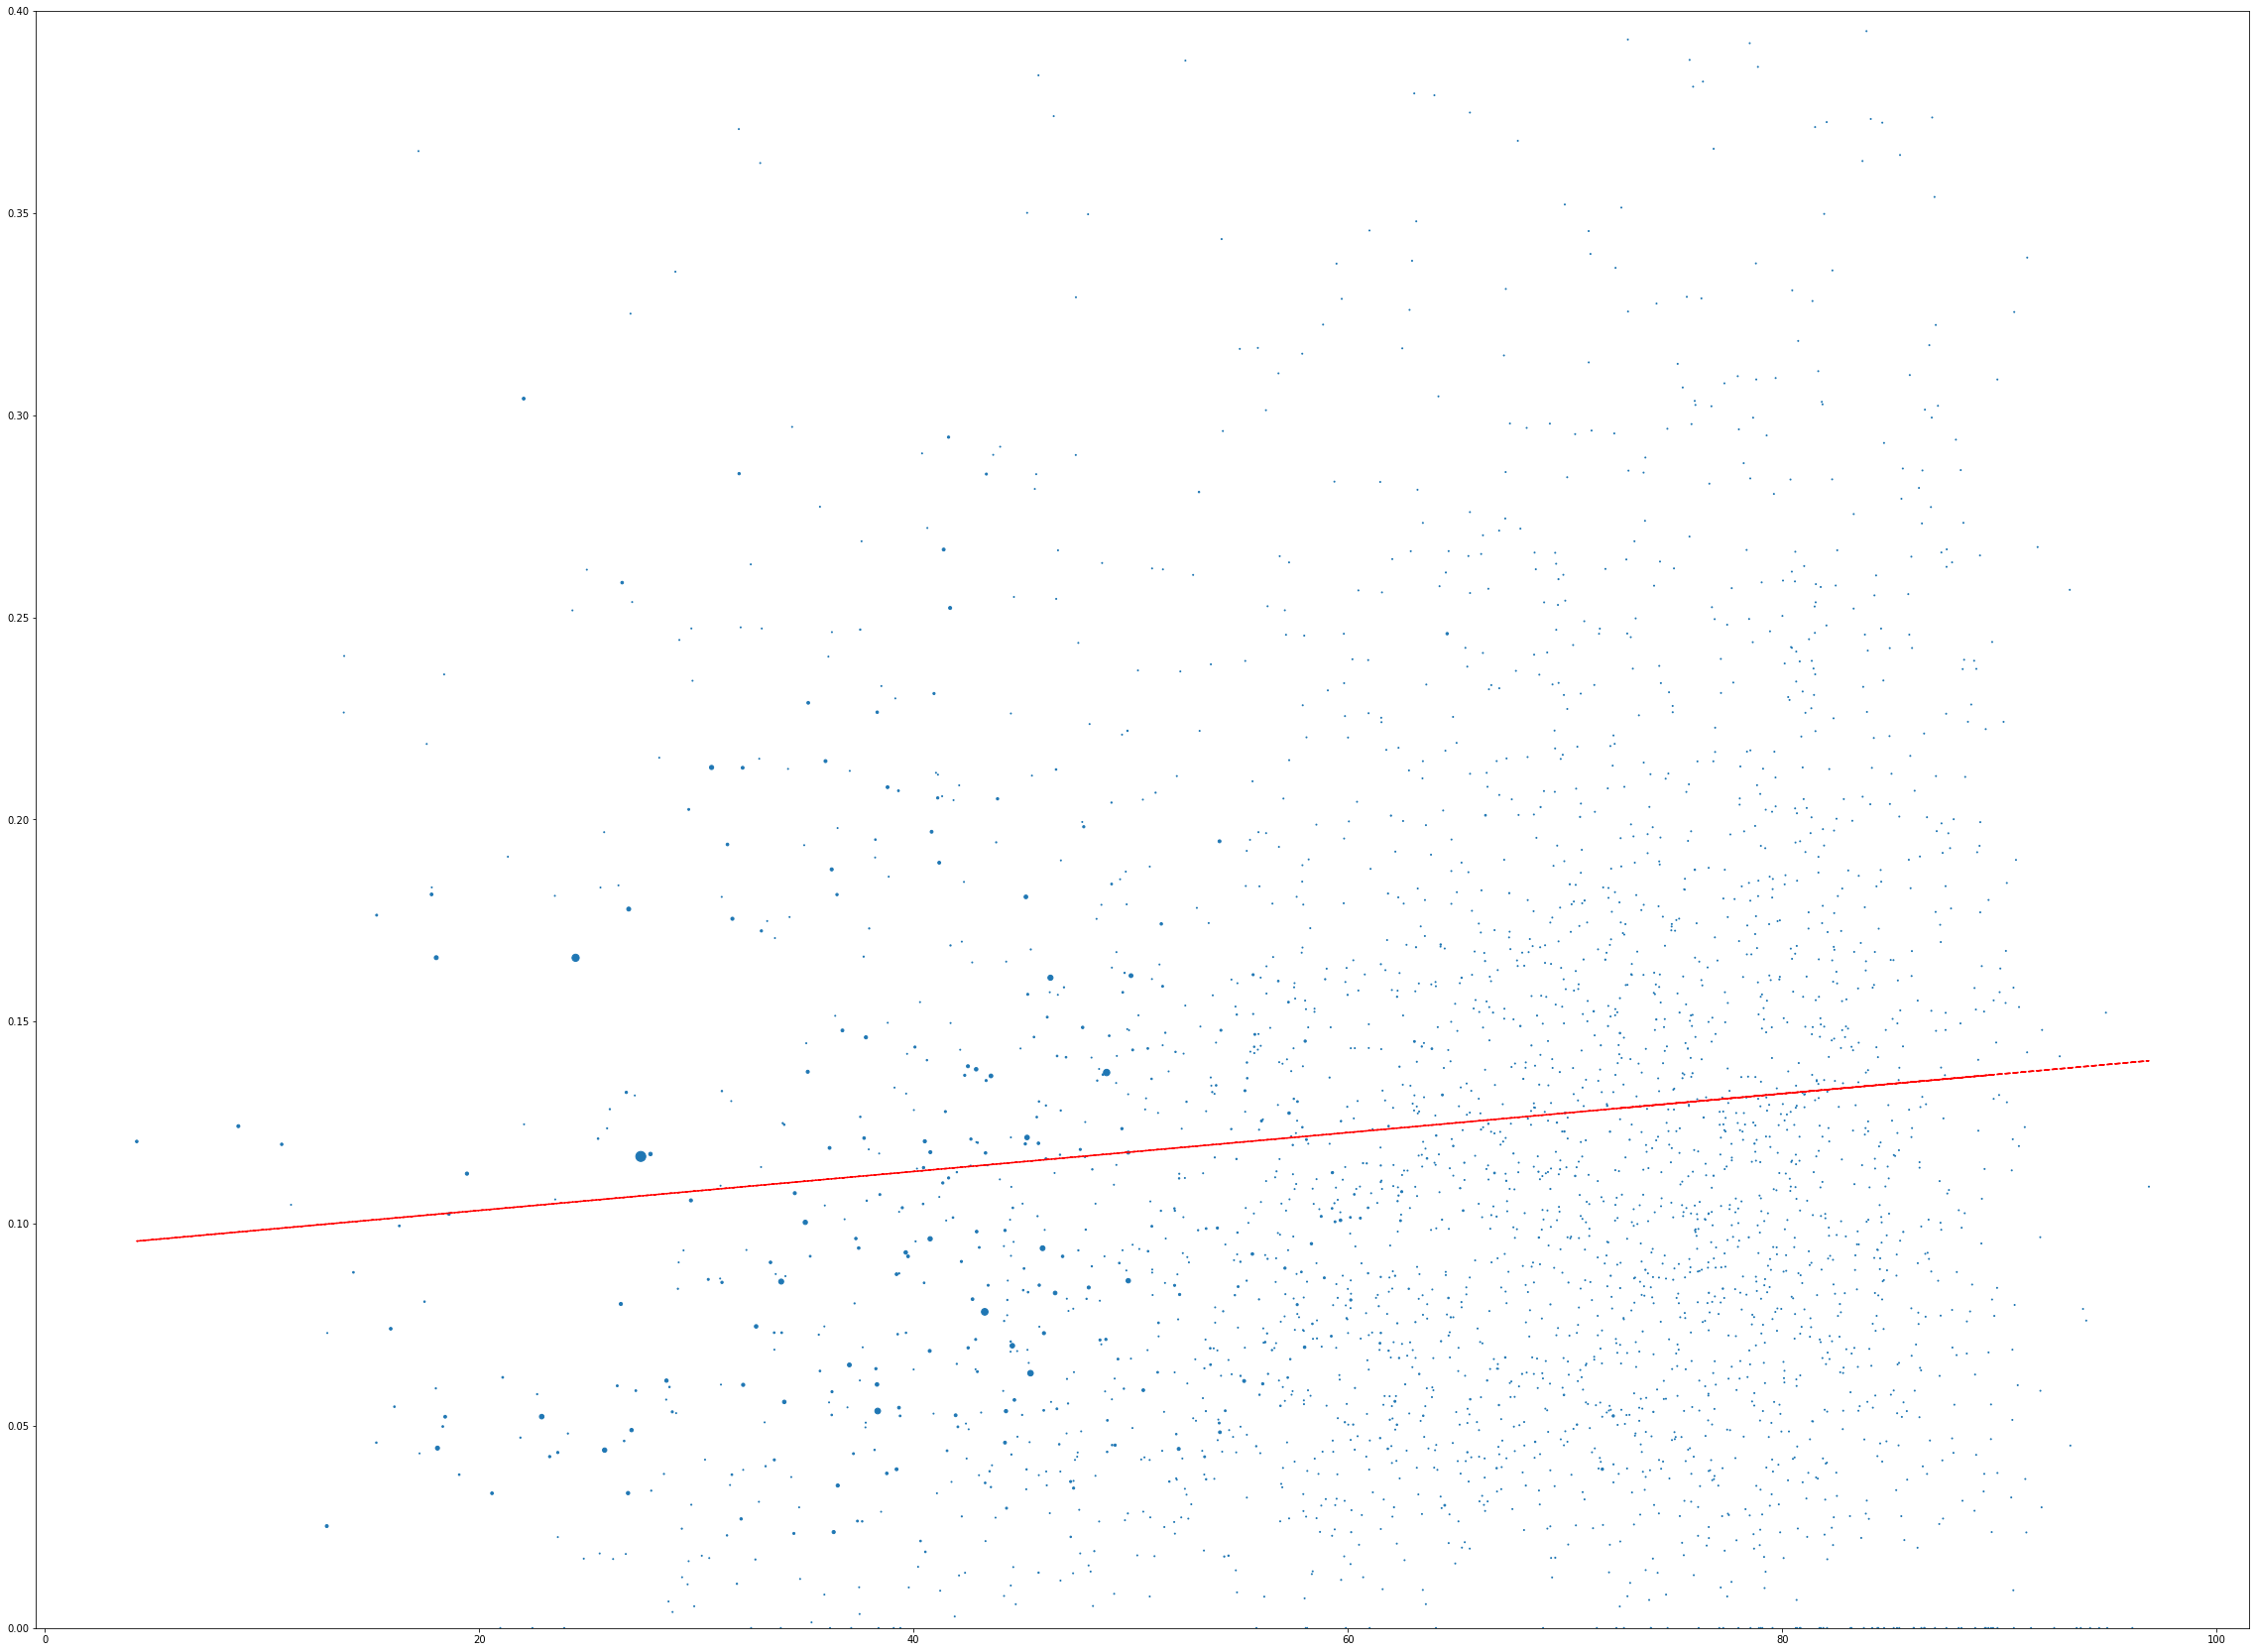

y=0.000481x+(0.093664)


In [20]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([float(i['trump_pct']) for i in joined])
y = np.array([float(i['deaths_per_100']) for i in joined])
area = np.array([max(1, i['population']/100000) for i in joined])
area = area
plt.figure(figsize=(40,30))
plt.scatter(x, y, s=area)
plt.ylim(0, 0.4)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

# the line equation:
print("y=%.6fx+(%.6f)"%(z[0],z[1]))
